In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import json
import re
from pathlib import Path
from mimas.helper.fileio import NumpyEncoder

import seaborn as sns
from matplotlib import rcParams
matplotlib_font_size = 12
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.size'] = matplotlib_font_size
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['svg.fonttype'] = 'none'

path_data = Path().cwd().parent / 'data'

path_figures = Path().cwd().parent / 'figures'
path_figures.mkdir(parents=True, exist_ok=True)


In [2]:
datasource = "mona"

path_source = {"benchmark_result": "open_search", "benchmark_identity_result": "identity_search",
               "benchmark_neutral_loss_result": "neutral_loss_search", "benchmark_hybrid_search_result": "hybrid_search"}
all_df = []
for p in path_source:
    for file_data in (path_data/datasource/p).glob("charge_*-100_against_1000000.csv"):
        df = pd.read_csv(file_data)
        df['path'] = file_data.parent.stem
        df['file'] = file_data.stem
        all_df.append(df)

df = pd.concat(all_df)

df["charge"] = df["file"].str.extract(r"charge_(..?)-")
df["library_size"] = df["file"].str.extract(r"against_(.+)$").astype(int)

# Replace path with name
df["search"] = df["path"].replace(path_source)
df


,id,fast_entropy_search,native_entropy_search,max_difference_for_fast_entropy_search,blink,matchms,max_difference_for_blink,query_number,library_number,path,file,matchms_library_number,charge,library_size,search
0,0,0.000424,95.044576,0.000002,0.728695,27.327513,0.045209,100,1000000,benchmark_result,charge_P-100_against_1000000,NaN,P,1000000,open_search
1,1,0.000564,97.185109,0.000001,0.699921,25.613551,0.114015,100,1000000,benchmark_result,charge_P-100_against_1000000,NaN,P,1000000,open_search
2,2,0.000709,96.517966,0.000001,0.713071,26.027899,0.043310,100,1000000,benchmark_result,charge_P-100_against_1000000,NaN,P,1000000,open_search
3,3,0.000593,96.246270,0.000002,0.701563,26.632339,0.186183,100,1000000,benchmark_result,charge_P-100_against_1000000,NaN,P,1000000,open_search
4,4,0.000592,95.023660,0.000002,0.714035,25.889213,0.017369,100,1000000,benchmark_result,charge_P-100_against_1000000,NaN,P,1000000,open_search
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.021801,NaN,NaN,NaN,25.116548,NaN,100,1000000,benchmark_hybrid_search_result,charge_N-100_against_1000000,NaN,N,1000000,hybrid_search
96,96,0.024570,NaN,NaN,NaN,25.614256,NaN,100,1000000,benchmark_hybrid_search_result,charge_N-100_against_1000000,NaN,N,1000000,hybrid_search
97,97,0.036599,NaN,NaN,NaN,27.340113,NaN,100,1000000,benchmark_hybrid_search_result,charge_N-100_against_1000000,NaN,N,1000000,hybrid_search
98,98,0.031187,NaN,NaN,NaN,25.480344,NaN,100,1000000,benchmark_hybrid_search_result,charge_N-100_against_1000000,NaN,N,1000000,hybrid_search


In [3]:
df_data = df[["fast_entropy_search", "native_entropy_search", "matchms", "blink", "charge", "search"]]
df_data = df_data.melt(id_vars=["charge", "search"], var_name="method", value_name="time")
df_data.dropna(inplace=True)
df_data


,charge,search,method,time
0,P,open_search,fast_entropy_search,0.000424
1,P,open_search,fast_entropy_search,0.000564
2,P,open_search,fast_entropy_search,0.000709
3,P,open_search,fast_entropy_search,0.000593
4,P,open_search,fast_entropy_search,0.000592
...,...,...,...,...
2995,P,neutral_loss_search,blink,0.741636
2996,P,neutral_loss_search,blink,0.747000
2997,P,neutral_loss_search,blink,0.732774
2998,P,neutral_loss_search,blink,0.740909


identity_search: ['fast_entropy_search' 'native_entropy_search' 'matchms']
open_search: ['fast_entropy_search' 'native_entropy_search' 'matchms' 'blink']
neutral_loss_search: ['fast_entropy_search' 'native_entropy_search' 'matchms' 'blink']
hybrid_search: ['fast_entropy_search' 'matchms']


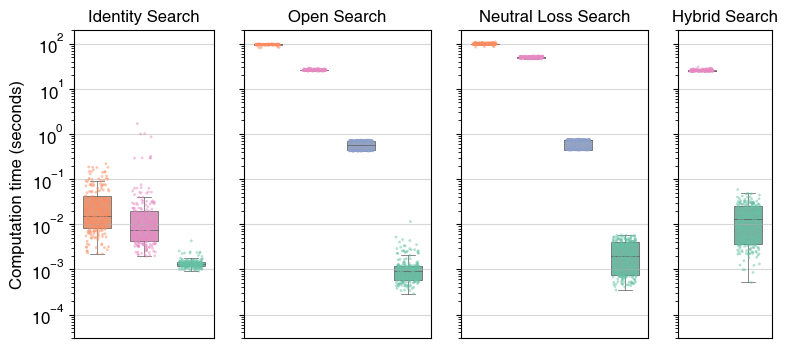

In [4]:
df_plot = df_data

hue_order = ["native_entropy_search", "matchms", "blink", "fast_entropy_search"]
color_palette_set2 = sns.color_palette("Set2", 4)
color_palette = {
    "native_entropy_search": color_palette_set2[1],
    "matchms": color_palette_set2[3],
    "blink": color_palette_set2[2],
    "fast_entropy_search": color_palette_set2[0],
}

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(9, 4), width_ratios=[3, 4, 4, 2],
                         sharex=False, sharey=True)

for i, search in enumerate(["identity_search", "open_search", "neutral_loss_search", "hybrid_search"]):
    df_plot = df_data[df_data["search"] == search]
    # Check methods
    print(f"{search}: {df_plot['method'].unique()}")
    methods_list= df_plot['method'].unique()
    ax = axes[i]
    ax.grid(True, which="major", axis="y", ls="-", alpha=0.5)
    ax.set_title(search.replace("_", " ").title(), fontsize=matplotlib_font_size)
    sns.stripplot(data=df_plot, x="method", y="time", hue="method", hue_order=hue_order, palette=color_palette,order=[x for x in hue_order if x in methods_list],
                  dodge=False, jitter=0.25, size=2, alpha=0.5, linewidth=0, ax=ax, legend=False)
    sns.boxplot(data=df_plot, x="method", y="time", hue="method", hue_order=hue_order, palette=color_palette,order=[x for x in hue_order if x in methods_list],
                linewidth=0.5, fliersize=0, ax=ax, dodge=False, width=0.6)
    ax.legend().remove()

    ax.set_yscale('log')
    ax.set_ylim(3e-5, 200)
    ax.set_ylabel("Computation time (seconds)")
    ax.set_xlabel("")
    # Remove x-axis ticks
    ax.set_xticklabels([])
    ax.set_xticks([])

plt.savefig(path_figures / f"19_compare_all_search_in_1m_spectra.svg", bbox_inches='tight', pad_inches=0.1)